In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/ALDA/ECONet/train.csv")
Y = df.target

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


False    6358102
True      235172
Name: target, dtype: int64

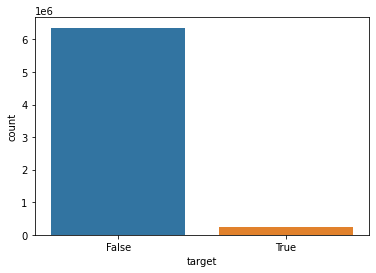

In [3]:
import seaborn as sns

sns.countplot(df['target'])
Y.value_counts()

In [4]:
from datetime import datetime

df["Ob"] = df["Ob"].apply(lambda x: datetime.strptime(x,"%m/%d/%Y %M:%S"))
df['year'] = df['Ob'].dt.year
df['month'] = df['Ob'].dt.month
df['day'] = df['Ob'].dt.day
df['minute'] = df['Ob'].dt.minute
df['seconds'] = df['Ob'].dt.second

In [5]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Station', 'Ob', 'measure','target'], axis=1), Y, train_size=0.75, shuffle=True, random_state=123)

# Split the dataset into test and train

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'ECONet data distribution after Resampling')

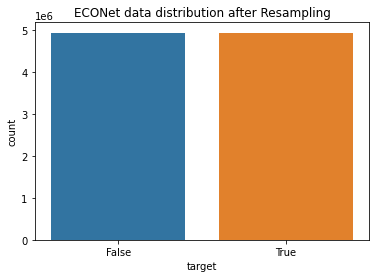

In [6]:
df_majority = y_train==False
df_minority = y_train==True

# upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority_upsampled, df_majority])

sns.countplot(df_upsampled).set_title("ECONet data distribution after Resampling")
print(df_upsampled['target'].value_counts())

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

#classifier = LogisticRegression(solver='liblinear')
classifier = RandomForestClassifier()
classifier.fit(X_train_norm, y_train)

pred_train = classifier.predict(X_train_norm)
pred_test = classifier.predict(X_test_norm)

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print('Accuracy for training data')
print(accuracy_score(y_train, pred_train))
print('Accuracy for test data')
print(accuracy_score(y_test, pred_test))
print()
print('Confusion matrix for test data')
print(confusion_matrix(y_test, pred_test))
print()
print('Classification report for test data')
print(classification_report(y_test, pred_test))

Accuracy for training data
0.9997029295514317
Accuracy for test data
0.9975447713701049

Confusion matrix for test data
[[1588309    1188]
 [   2859   55963]]

Classification report for test data
              precision    recall  f1-score   support

       False       1.00      1.00      1.00   1589497
        True       0.98      0.95      0.97     58822

    accuracy                           1.00   1648319
   macro avg       0.99      0.98      0.98   1648319
weighted avg       1.00      1.00      1.00   1648319



Logistic: f1=0.965 auc=0.993


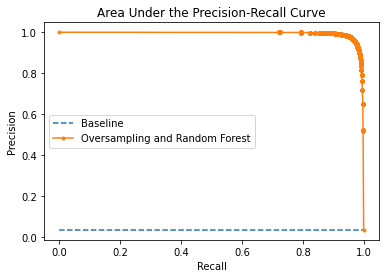

In [9]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

# predict probabilities
lr_probs = classifier.predict_proba(X_test_norm)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, pred_test), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Baseline')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Oversampling and Random Forest')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.title('Area Under the Precision-Recall Curve')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()